In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging
import copy

import numpy as np
from astropy.table import Table as ApTable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, sim
import lsst.meas.deblender.utils as debUtils
from lsst.meas.deblender.baseline import newDeblend

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Load the Simulated Data

In [2]:
def loadSimData(testNbr, filters):
    logger.info("Loading Data for test {0}".format(testNbr))
    dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
    imgFilename = os.path.join(dataPath, "test"+str(testNbr)+"/{0}_{1}.fits")
    catFilename = os.path.join(dataPath, "test"+str(testNbr)+"/det_merge.fits")
    simFilename = os.path.join(dataPath, "test"+str(testNbr)+"/catalog_true.fits")
    expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
    return expDb

# Match the peaks and the simulated sources

And note any sources without matches, or multiple sources with the same match

In [3]:
filters = ["g","r", "i","z",'y']
expDbs = [loadSimData(n, filters) for n in range(1,2)]
peakTables = []
simTables = []
for n, expDb in enumerate(expDbs):
    logger.info("Test {0}".format(n+1))
    # Estimate the noise in the image
    avgNoise = sim.getNoise(expDb.calexps)
    # Build a table with 
    peakTable = sim.buildPeakTable(expDb, filters)
    peakTables.append(peakTable)
    #tbl.add_row([1,0,402,60,False, tbl[0]["Peak"]])
    simTable, idx = sim.matchToRef(peakTable, expDb.simTable, filters, avgNoise=avgNoise,
                                 display=False)#, calexp=expDb.calexps[1])
    simTables.append(simTable)
    # Calculate the flux for isolated (non-blended) sources
    sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable)

nmfPeakTables = copy.deepcopy(peakTables)

INFO:lsst.meas.deblender:Loading Data for test 1
INFO:lsst.meas.deblender.proximal:Total parents: 25
INFO:lsst.meas.deblender.proximal:Unblended sources: 17
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 8
INFO:lsst.meas.deblender:Test 1
INFO:lsst.meas.deblender:Sources not detected: 14


# Deblend and Calculate Flux

In [4]:
deblenderResults = []
for n,expDb in enumerate(expDbs):
    logger.info("Deblending Test {0}".format(n+1))
    # Run the old deblender and calculate the flux of blended objects
    deblenderResult = sim.deblendSimExposuresOld(filters, expDb, peakTables[n])
    deblenderResults.append(deblenderResult)
    
    # Run the new deblender and calculate the flux of blended objects
    expDb.deblend(maxiter=200)
    #expDb.deblend()
    sim.calculateNmfFlux(expDb, nmfPeakTables[n])

# Caculate the flux portion from the original data using the
# NMF deblender output to weight each peak
apportionTables = copy.deepcopy(peakTables)
for n, expDb in enumerate(expDbs):
    sim.calculateFluxPortion(expDb, apportionTables[n])

INFO:lsst.meas.deblender:Deblending Test 1


constraints MMMMMMMMMMMMMMMMMMMMMMM
0 0.70386091192 0 20.5454786703 199 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1 0.00117287985805 199 15.2396428758 199 [16298, 17338, 16800, 16763, 16705, 16550, 16396, 17978, 17735, 17733, 17248, 17023, 17663, 18228, 18123, 16366, 17441, 16838, 17056, 17303, 16656, 17684, 17594]
2 0.00122290226229 199 11.3589933872 199 [20231, 20281, 20021, 20352, 20230, 20264, 20289, 20366, 20293, 20186, 20362, 20291, 19994, 19957, 20653, 22028, 19841, 19708, 19615, 20294, 20578, 20560, 20235]
3 0.000914849234713 199 8.50727247377 146 [19687, 19464, 19319, 19972, 20019, 19869, 19977, 19557, 19457, 19637, 19291, 20211, 18981, 19356, 20054, 21177, 19510, 18906, 19028, 19769, 19884, 19715, 19450]
4 0.000687342821056 199 6.37746355267 109 [19436, 19105, 18967, 19833, 19637, 19646, 19712, 18970, 18925, 19283, 18996, 19848, 17984, 18599, 19661, 19180, 19068, 17348, 18389, 19433, 17928, 19611, 18975]
5 0.000515807322612 199 4.78233634044 82 [18

# Compare Deblender results to True Values

INFO:lsst.meas.deblender:Total Simulated Sources: 138
INFO:lsst.meas.deblender:Total Detected Sources: 138
INFO:lsst.meas.deblender:Total Matches: 127
INFO:lsst.meas.deblender:Matched Isolated sources: 17
INFO:lsst.meas.deblender:Matched Blended sources: 110
INFO:lsst.meas.deblender:Total Duplicates: 0


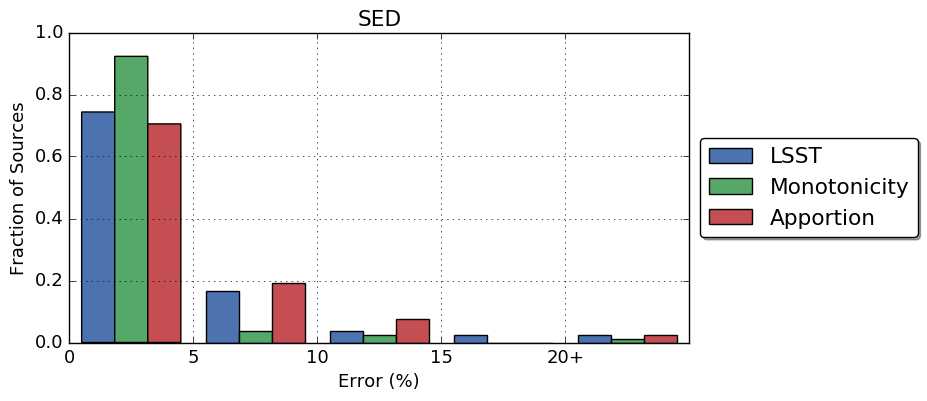

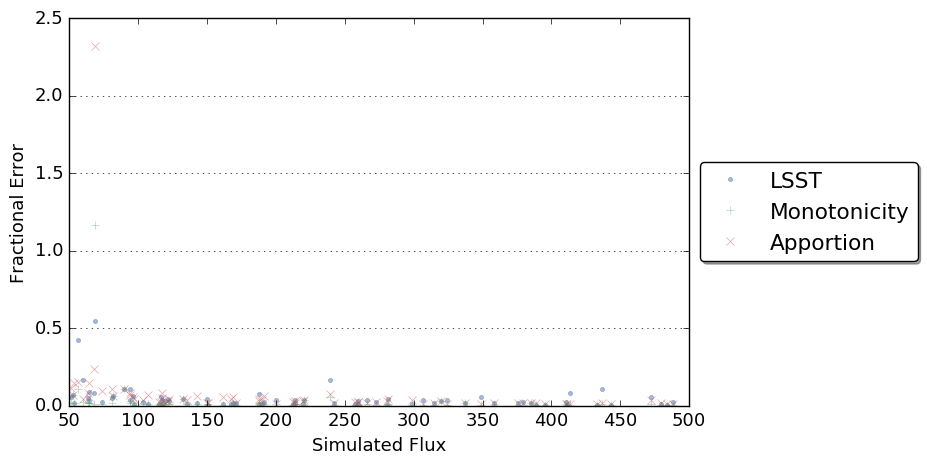

/Users/fred/lsst/code/meas_deblender/python/lsst/meas/deblender/sim.py:341: RuntimeWarning: invalid value encountered in less
  lowFlux = simTable[flux]<minFlux


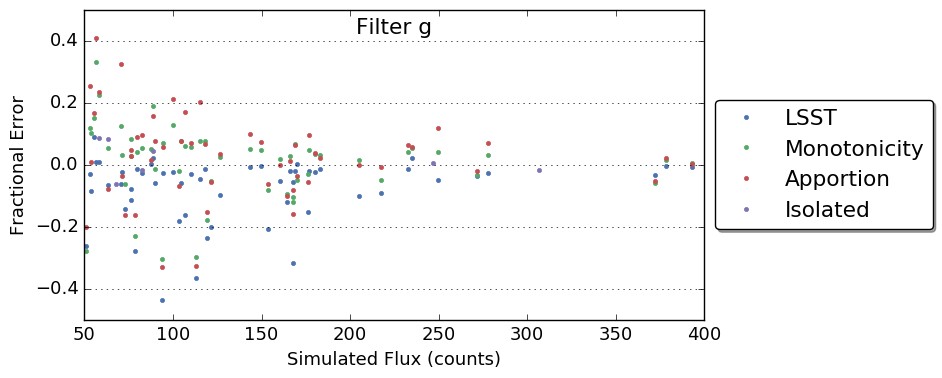

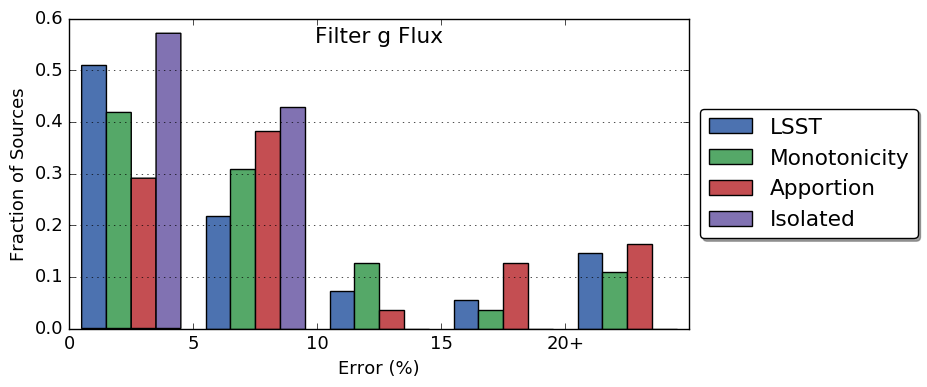

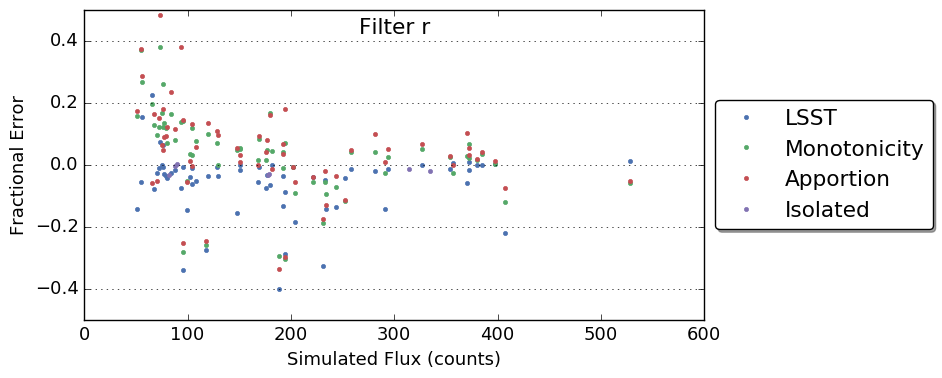

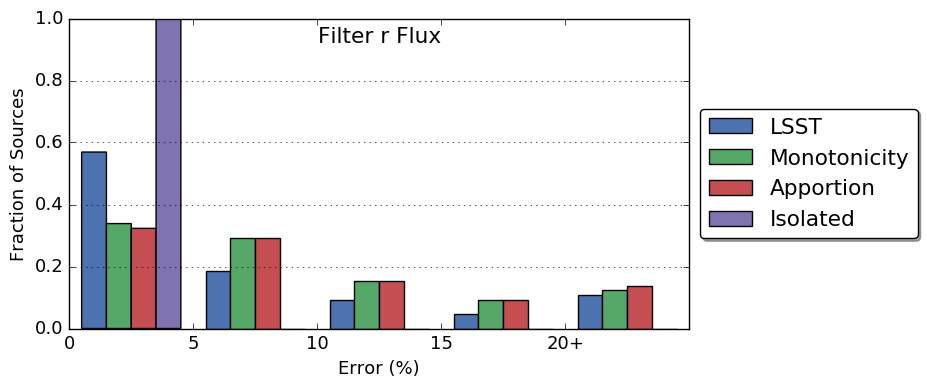

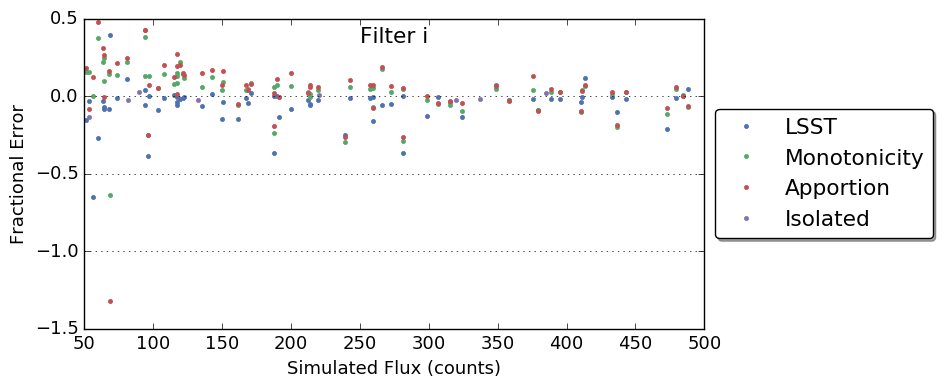

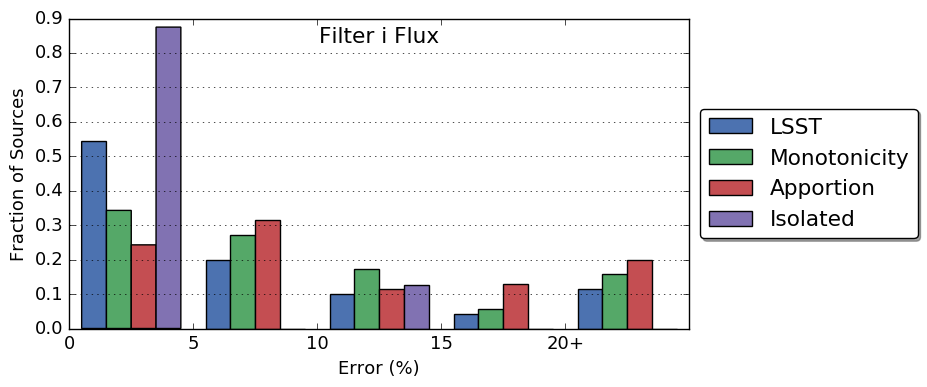

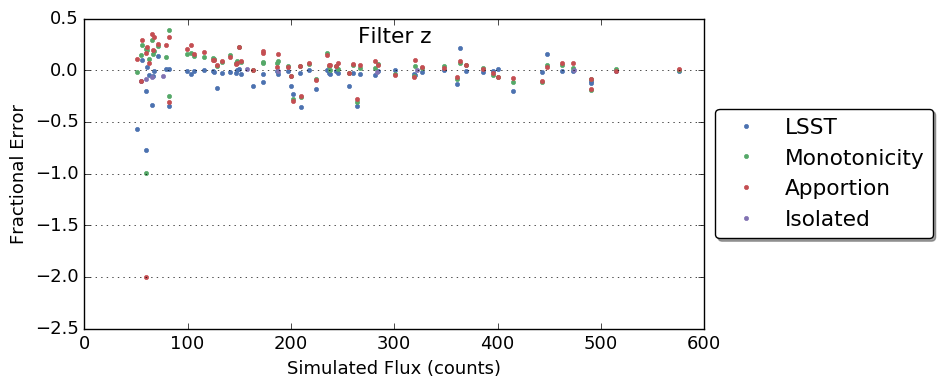

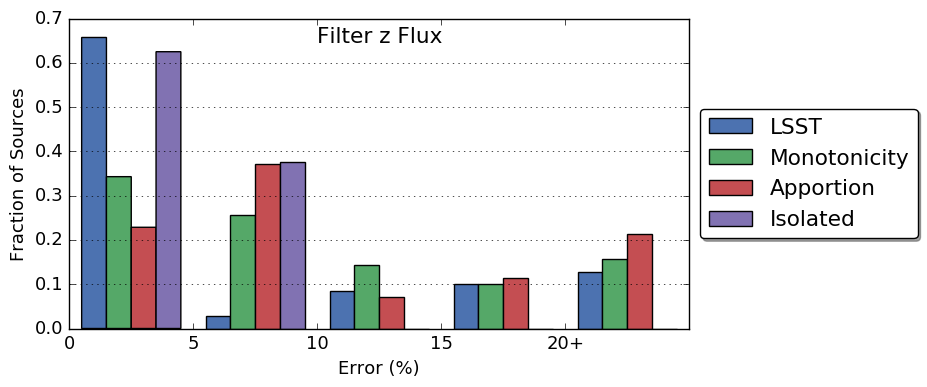

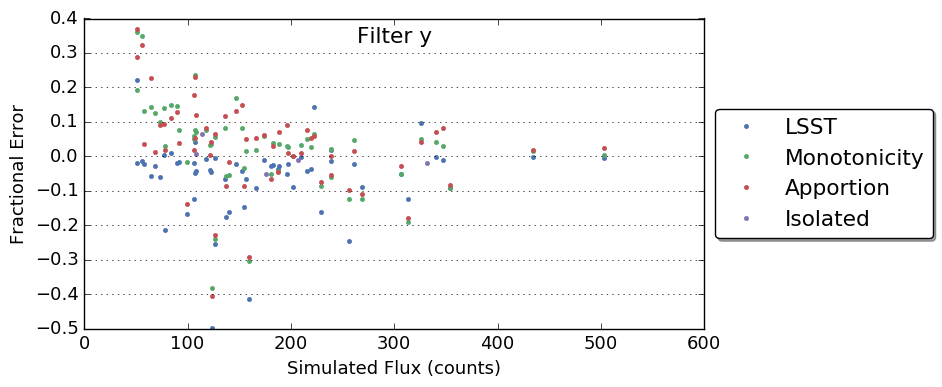

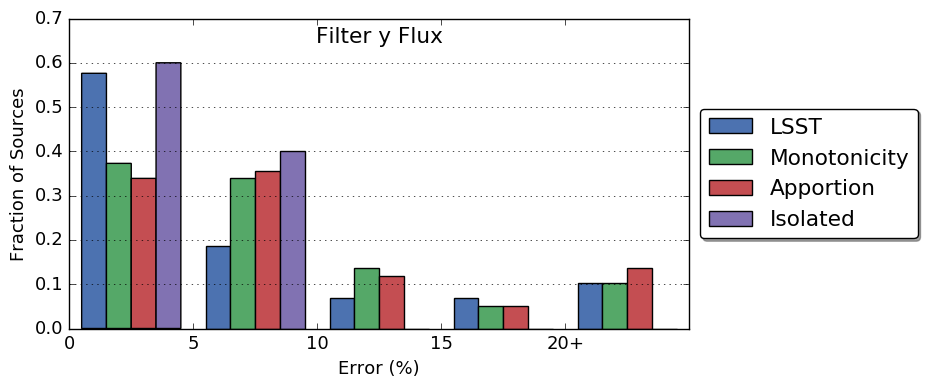

In [5]:
#peakTable, simTable, nmfPeakTable = sim.compareMeasToSim(peakTables, simTables, nmfPeakTables, filters)
deblendedTblDict = OrderedDict([
    ("LSST", peakTables),
    ("Monotonicity", nmfPeakTables),
    ("Apportion", apportionTables)
])
deblendedTables = sim.compareMeasToSim(simTables, deblendedTblDict, filters)

INFO:lsst.meas.deblender:Parent 1


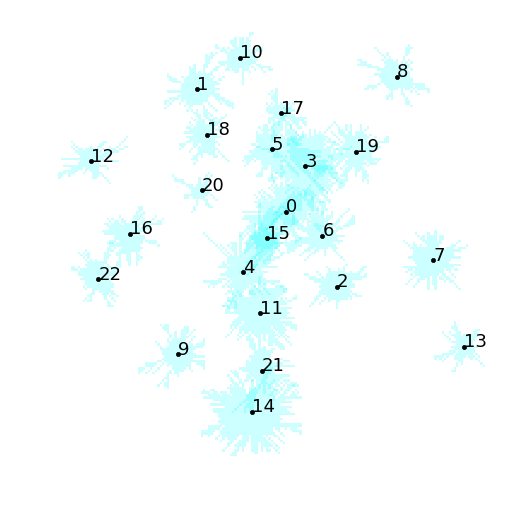

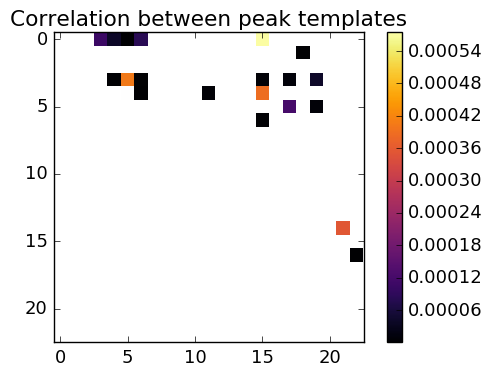

INFO:lsst.meas.deblender:Parent 4


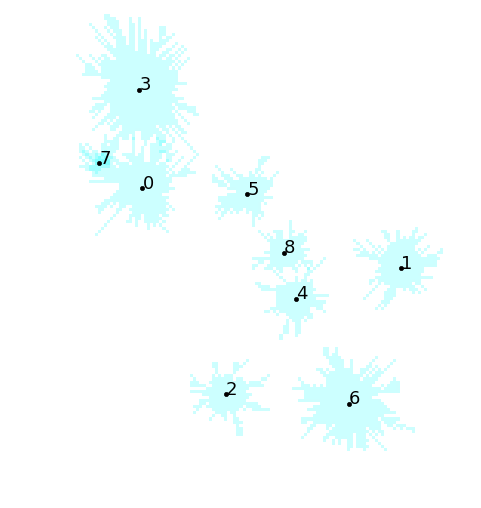

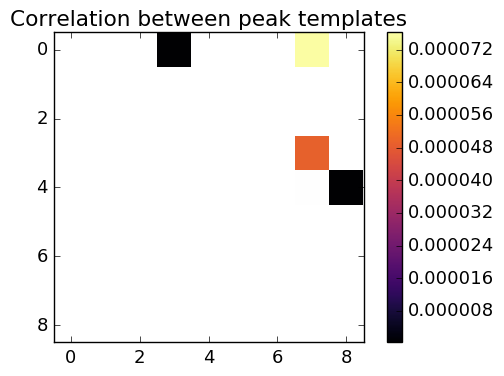

INFO:lsst.meas.deblender:Parent 11


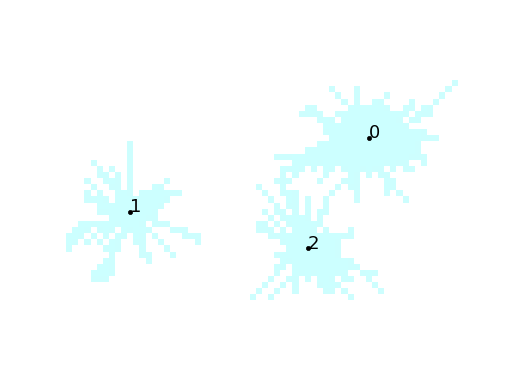

/Users/fred/lsst/code/lsstswig2/miniconda/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


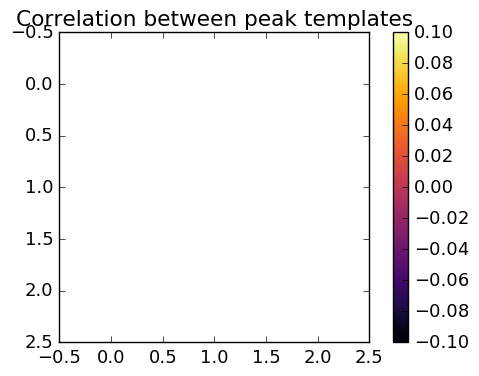

INFO:lsst.meas.deblender:Parent 19


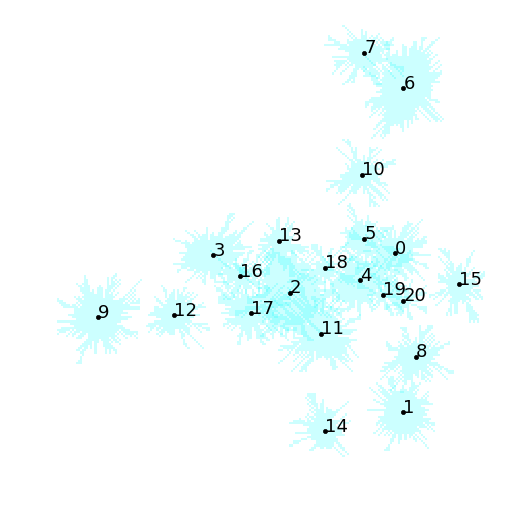

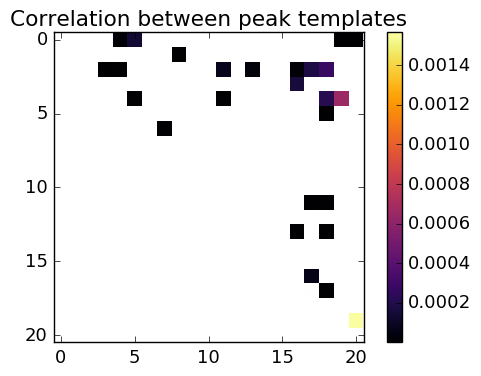

INFO:lsst.meas.deblender:Parent 21


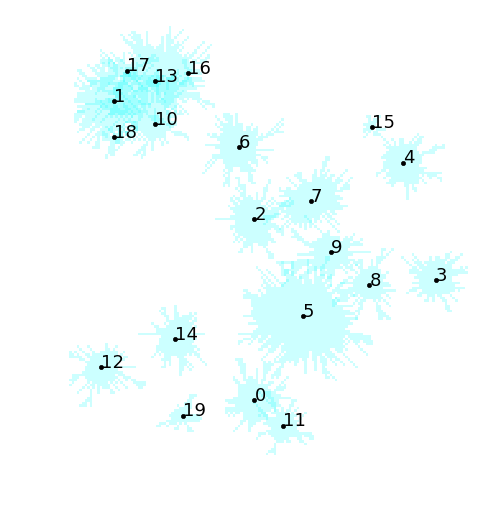

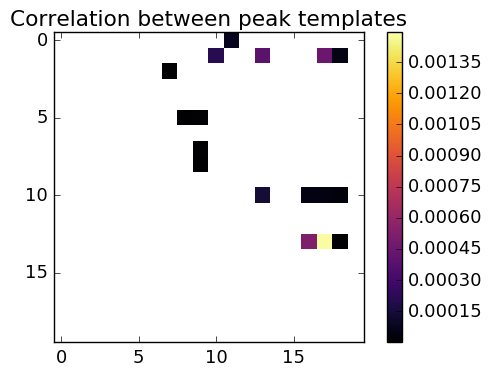

INFO:lsst.meas.deblender:Parent 22


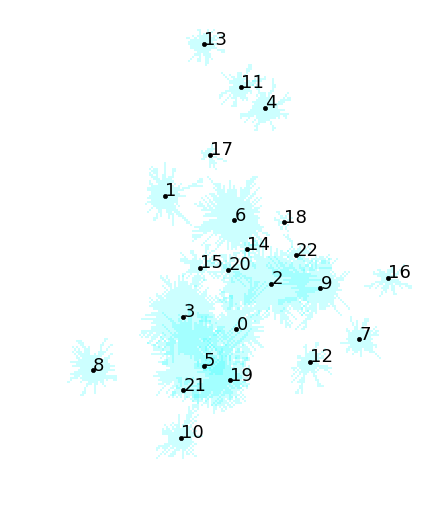

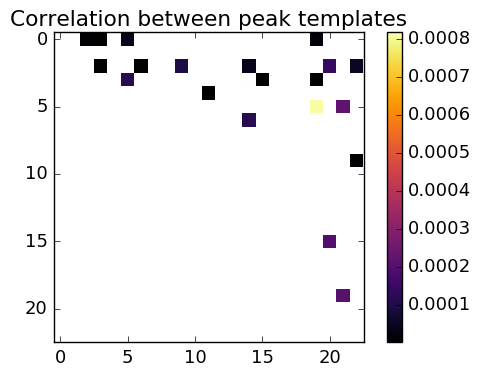

INFO:lsst.meas.deblender:Parent 35


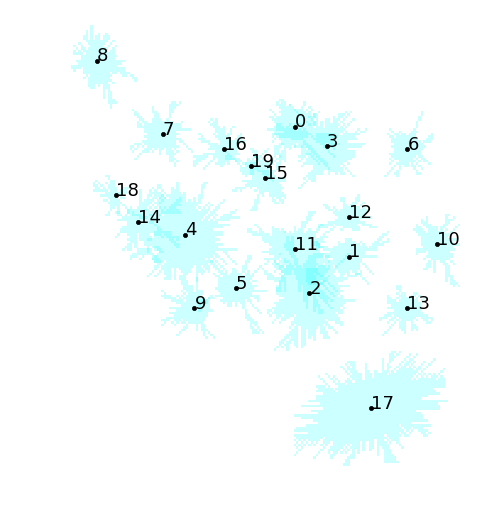

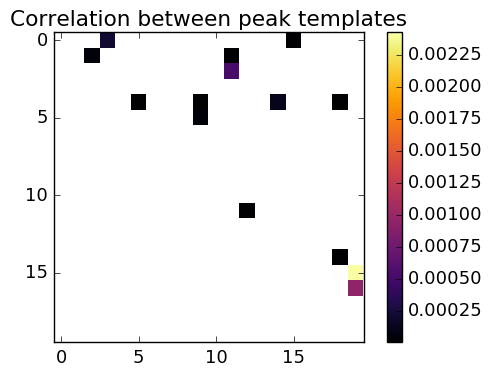

INFO:lsst.meas.deblender:Parent 46


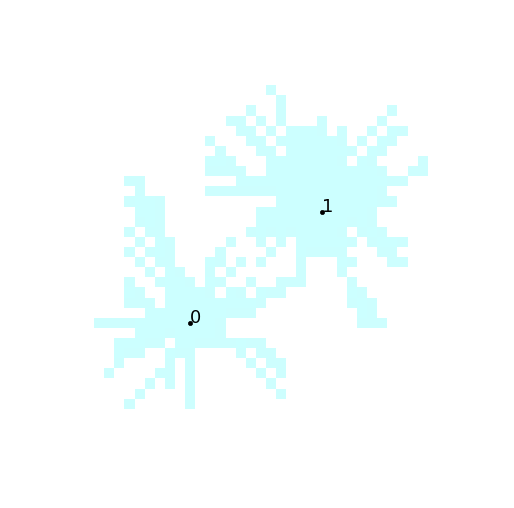

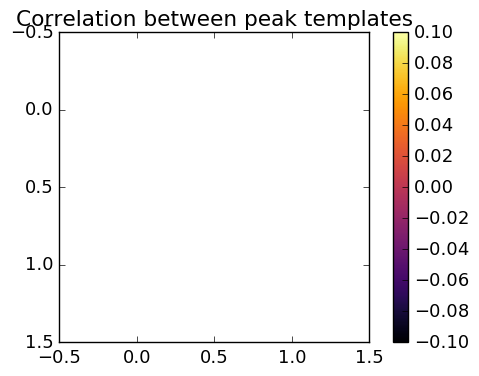

In [6]:
minFlux = .1
sim.checkForDegeneracy(expDb, minFlux)